
== Escenario 1 (repeticiones=30) ==
Pico medio infectados: 100.00 ± 0.00
Tiempo medio del pico: 9.53 ± 1.12
% medio recuperados: 99.00% ± 0.00%


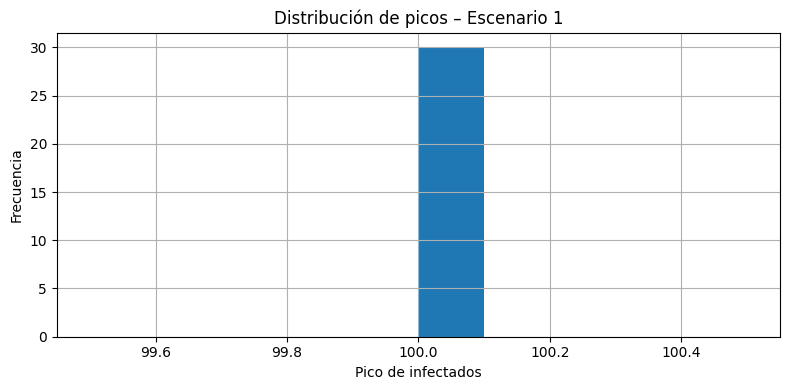


== Escenario 1 (repeticiones=100) ==
Pico medio infectados: 100.00 ± 0.00
Tiempo medio del pico: 9.36 ± 1.25
% medio recuperados: 99.00% ± 0.00%


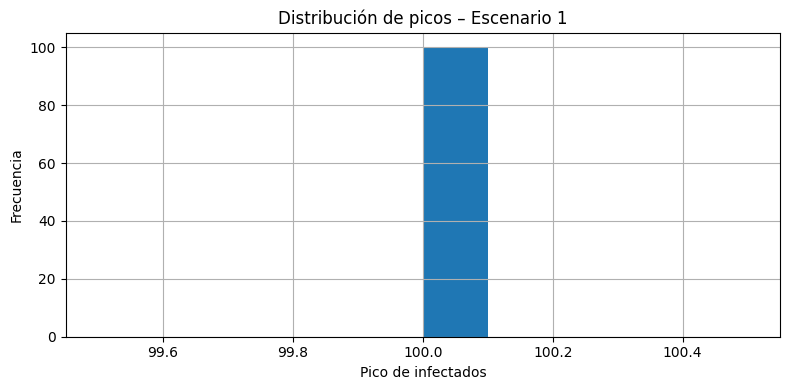


== Escenario 2 (repeticiones=30) ==
Pico medio infectados: 26.23 ± 12.18
Tiempo medio del pico: 49.43 ± 9.77
% medio recuperados: 23.07% ± 15.40%


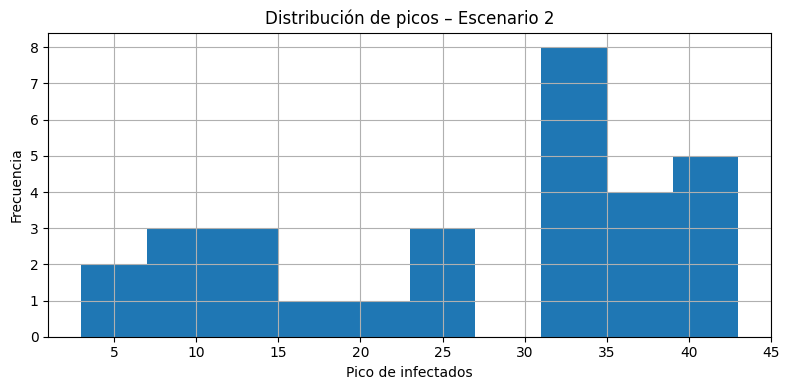


== Escenario 2 (repeticiones=100) ==
Pico medio infectados: 26.59 ± 11.56
Tiempo medio del pico: 54.34 ± 4.71
% medio recuperados: 19.79% ± 13.46%


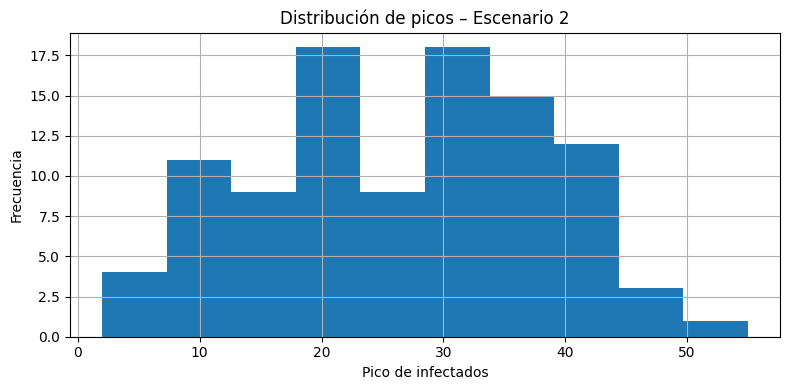

In [11]:
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np


class Persona:
    def __init__(self, id, infect_prob, rec_time):
        self.id = id
        self.estado = "S"
        self.infect_prob = infect_prob
        self.rec_time = rec_time
        self.en_proceso = False
        self.historial = []

    def infectar(self, env):
        if self.estado == "S" and not self.en_proceso:
            self.en_proceso = True
            if random.random() < self.infect_prob:
                self.estado = "I"
                yield env.timeout(self.rec_time)
                self.estado = "R"
            self.en_proceso = False


def run_scenario_once(infect, infect_prob, rec_time,
                      num_personas=100, duracion=30, semilla=None):
    if semilla is not None:
        random.seed(semilla)
    env = simpy.Environment()
    personas = [Persona(i, infect_prob, rec_time) for i in range(num_personas)]
    personas[0].estado = "I"

    tiempos, I = [], []

    while env.now < duracion:
        for p in personas:
            p.historial.append((env.now, p.estado))
        for p in personas:
            if p.estado == "I":
                vecinos = random.sample(personas, infect)
                for v in vecinos:
                    env.process(v.infectar(env))
        i_count = sum(p.estado == "I" for p in personas)
        tiempos.append(env.now)
        I.append(i_count)
        env.run(until=env.now + 1)

    # métricas
    pico_idx = int(np.argmax(I))
    tiempo_pico = tiempos[pico_idx]
    valor_pico = I[pico_idx]
    porcentaje_recuperados = sum(p.estado == "R" for p in personas) / num_personas * 100

    return valor_pico, tiempo_pico, porcentaje_recuperados


def run_scenario_multiple(nombre, infect, infect_prob, rec_time,
                          num_personas=100, duracion=30,
                          repeticiones=30):
    metrics = []  # lista de tuplas (pico, t_pico, %R)
    for run in range(repeticiones):
        sem = None if run == 0 else random.randint(0, 1_000_000)
        pico, t_pico, pct_R = run_scenario_once(
            infect, infect_prob, rec_time,
            num_personas=num_personas, duracion=duracion,
            semilla=sem
        )
        metrics.append((pico, t_pico, pct_R))

    # convertir a arrays
    arr = np.array(metrics)
    print(f"\n== {nombre} (repeticiones={repeticiones}) ==")
    # Calc promedio y variacion
    print(f"Pico medio infectados: {arr[:, 0].mean():.2f} ± {arr[:, 0].std():.2f}")
    print(f"Tiempo medio del pico: {arr[:, 1].mean():.2f} ± {arr[:, 1].std():.2f}")
    print(f"% medio recuperados: {arr[:, 2].mean():.2f}% ± {arr[:, 2].std():.2f}%")

    # histograma de picos
    plt.figure(figsize=(8, 4))
    plt.hist(arr[:, 0], bins=10)
    plt.xlabel("Pico de infectados")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de picos – {nombre}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics


# ======== Escenarios ========
escenarios = [
    {"nombre": "Escenario 1", "infect": 5, "infect_prob": 0.3, "rec_time": 14},
    {"nombre": "Escenario 2", "infect": 1, "infect_prob": 0.1, "rec_time": 19},
]

# Ejecutar y recolectar métricas
todos_metrics = {}
for sc in escenarios:
    metrics_30 = run_scenario_multiple(
        sc["nombre"], sc["infect"], sc["infect_prob"], sc["rec_time"],
        num_personas=100, duracion=60, repeticiones=30
    )
    metrics_100 = run_scenario_multiple(
        sc["nombre"], sc["infect"], sc["infect_prob"], sc["rec_time"],
        num_personas=100, duracion=60, repeticiones=100
    )
    todos_metrics[sc["nombre"]] = {"30": metrics_30, "100": metrics_100}

# Ahora `todos_metrics` contiene los resultados de cada escenario y repetición

